In [1]:
import json
import pandas as pd
import os

df = pd.DataFrame()
for dirname, _, filenames in os.walk('../data/1633/'):
    for filename in filenames:
        data = {}
        with open(os.path.join(dirname, filename),'r') as file:
            d = json.loads(file.read())
        data['date'] = d['Indices']['NDVI']['Serie Processada']['Data']
        data['indices'] = d['Indices']['NDVI']['Serie Processada']['Indice']
        part = pd.DataFrame(data)
        part['date'] = pd.to_datetime(part['date'], format='%Y-%m-%d')
        print(os.path.join(dirname, filename))
        df = pd.concat([df, part])
df.head(10)

../data/1633/2021-2022.json
../data/1633/2014-2015.json
../data/1633/2016-2017.json
../data/1633/2019-2020.json
../data/1633/2020-2021.json
../data/1633/2018-2019.json
../data/1633/2015-2016.json
../data/1633/2017-2018.json
../data/1633/2022-2023.json


,date,indices
0,2021-07-04,0.737202
1,2021-07-12,0.635894
2,2021-07-20,0.465809
3,2021-07-28,0.391287
4,2021-08-05,0.377454
5,2021-08-13,0.367623
6,2021-08-21,0.340248
7,2021-08-29,0.305279
8,2021-09-06,0.280978
9,2021-09-14,0.275328


In [2]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.groupby(df.index).mean()
df = df.asfreq("W",method='backfill')
df = df.sort_index()
df.head(10)

,indices
date,
2014-07-06,0.566425
2014-07-13,0.508856
2014-07-20,0.508856
2014-07-27,0.494864
2014-08-03,0.475050
2014-08-10,0.434675
2014-08-17,0.396995
2014-08-24,0.386992
2014-08-31,0.406045


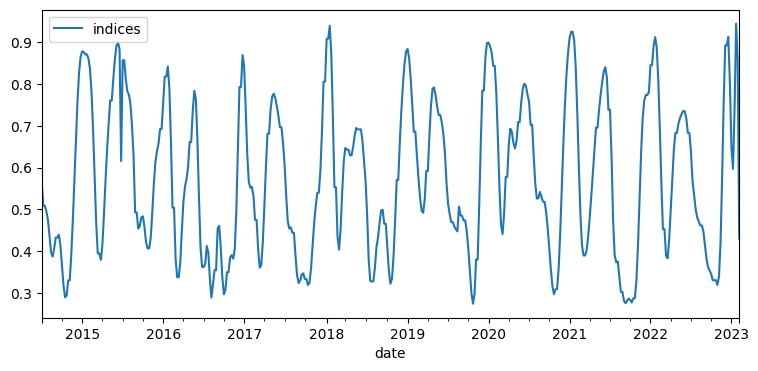

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 4))
df['indices'].plot(ax=ax, label='indices')
ax.legend()

In [4]:
from datetime import datetime

steps=10
X_train = df.loc[:datetime.strptime('2019-02-28', "%Y-%m-%d")]
X_test = df.loc[datetime.strptime('2019-02-28', "%Y-%m-%d"):datetime.strptime('2019-05-30', "%Y-%m-%d")]

In [5]:
X_test.head(10)

,indices
date,
2019-03-03,0.528584
2019-03-10,0.496818
2019-03-17,0.491831
2019-03-24,0.524270
2019-03-31,0.591785
2019-04-07,0.591785
2019-04-14,0.675518
2019-04-21,0.748064
2019-04-28,0.788163


In [6]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
auto = auto_arima(
    X_train['indices'],
    seasonal=True,
    stationary=True,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-771.616, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-147.553, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-678.798, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-401.805, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=435.858, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-746.343, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-772.807, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-724.767, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-758.415, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-771.666, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-772.973, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-771.689, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-769.648, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-741.254, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[

In [7]:
sarima = SARIMAX(X_train['indices'],order=auto.order,seasonal_order=(1,2,1,8),freq='W',enforce_stationarity=True)
model = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.14022D-01    |proj g|=  4.38161D+00


 This problem is unconstrained.



At iterate    5    f= -1.03449D+00    |proj g|=  1.40336D+00

At iterate   10    f= -1.20231D+00    |proj g|=  1.20313D+00

At iterate   15    f= -1.21145D+00    |proj g|=  7.75173D-01

At iterate   20    f= -1.23956D+00    |proj g|=  1.70719D-01

At iterate   25    f= -1.24312D+00    |proj g|=  4.33217D-01

At iterate   30    f= -1.24646D+00    |proj g|=  1.10906D-01

At iterate   35    f= -1.24758D+00    |proj g|=  1.44368D-02

At iterate   40    f= -1.24778D+00    |proj g|=  1.56143D-01

At iterate   45    f= -1.25082D+00    |proj g|=  2.49263D-01

At iterate   50    f= -1.25124D+00    |proj g|=  1.55506D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/pedro/workspace/POP-backend/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
forecast = model.get_forecast(steps=len(X_test))
print(type(forecast))
forecast = pd.DataFrame(forecast.predicted_mean)
forecast.head(10)

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


,predicted_mean
2019-03-03,0.558807
2019-03-10,0.552697
2019-03-17,0.509273
2019-03-24,0.521744
2019-03-31,0.540963
2019-04-07,0.596917
2019-04-14,0.621448
2019-04-21,0.641639
2019-04-28,0.669684
2019-05-05,0.685845


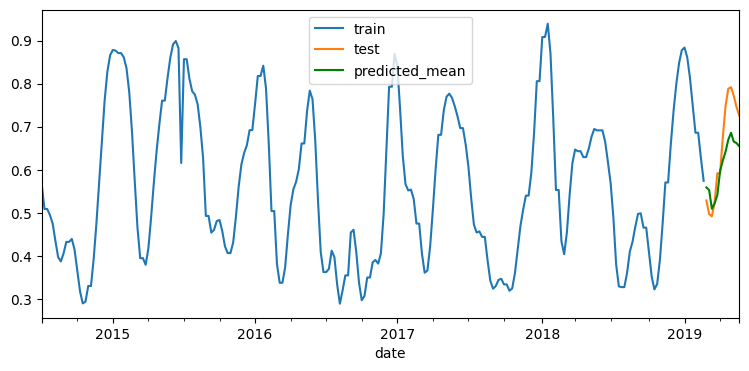

In [9]:
fig, ax=plt.subplots(figsize=(9, 4))
X_train['indices'].plot(ax=ax, label='train')
X_test['indices'].plot(ax=ax, label='test')
forecast.plot(ax=ax, label='predictions', color='green')
ax.legend()

In [10]:
import joblib

joblib.dump(model,'../model/1633.h5')

['../model/1633.h5']

In [11]:
from cassandra.cluster import Cluster
import uuid

cluster = Cluster(['localhost'])
session = cluster.connect('prediction')
for i in df.iterrows():
    query = "INSERT INTO data_series (data_id, id_municipio, valor_indice, data) VALUES (%s,%s, %s, %s)"
    session.execute(query, (uuid.uuid4(), 1633, i[1]['indices'], f'{i[0].year}-{i[0].month}-{i[0].day}'))
session.shutdown()
cluster.shutdown()